# Лабораторная работа №7. Решающие деревья. Усиление распознавателей

В данной лабораторной работе рассматривается использование бинарных распознающих деревьев и их ансамблей для решения задачи классификации.

Распознающим бинарным деревом называется дерево, с каждой вершиной $v$ которого связаны:

1. Некоторое подмножество $\mathcal{X}_v \subset \mathcal{X}$;
1. Подвыборка $\mathcal{D}_v \subset \mathcal{D}$ обучающей выборки $\mathcal{D}$, такая, что
$$
    \mathcal{D}_v = \left\{(\mathbf{x}, t) \in \mathcal{D} \,\vert\, \mathbf{x} \in \mathcal{X}_v\right\};
$$
1. Некоторое правило $f_v: \mathcal{X} \to \{0, 1\}$, определяющее разбиение множества $\mathcal{X}$ на $K$ непересекающихся подмножеств.

Цель построения дерева решений состоит либо в классификации векторов $\mathbf{x}$, либо в оценке математического ожидания отклика при данном значении $\mathbf{x}$.
Процесс принятия решения начинается с корневой вершины и состоит в последовательном применении правил, связанных с вершинами дерева.
Результатом этого процесса является определение терминальной вершины $v$, такой что $\mathbf{x} \in \mathcal{X}_v$.

Распознающие деревья редко применяют в качестве самостоятельного распознавателя, так как хорошего качества распознавания от них редко удается добиться.
Вместо этого их широко применяют в качестве «сырья» в методах усиления распознавателей, где синтез решения отдельных классификаторов, составляющих ансамбль, осуществляется путем их голосования.

Метод баггинга основан на формировании обучающей выборки для каждого классификатора ансамбля с помощью бутстрепа, то есть случайной выборки с возвращениями из исходной обучающей выборки.

Суть метода случайных лесов заключается в том, что для каждого дерева ансамбля на стадии расщепления вершин используется только некоторое подмножество случайно отбираемых признаков.
Чаще всего размерность такого подмножества выбирается близкой к $\sqrt{p}$, где $p$ $-$ размерность всего пространства признаков.

Идея метода бустинга состоит в том, что классификаторы ансамбля строятся последовательно, и на каждой итерации происходит коррекция (перевзвешивание) образов обучающей выборки.
Коррекция осуществляется таким образом, чтобы соответствующий классификатор дал меньше ошибок на тех образах, на которых часто делали ошибки классификаторы, построенные на предыдущих итерациях алгоритма.
Кроме того, каждому классификатору приписывается некоторый вес исходя из количества допущенных им ошибок.

In [1]:
import numpy as np
import sklearn as sk
import sklearn.datasets
import sklearn.model_selection
import sklearn.tree
import sklearn.ensemble
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['axes.grid'] = True
plt.rcParams['figure.constrained_layout.use'] = True

## Задание №1

Сгенерируйте датасет с 2 признаками размеро 3000 строк (`n_informative=2`, остальные параметры следует установить в 0).
В качестве `random_state` используйте свой порядковый номер в списке.
Разделите датасет на обучающую и тестовую выборки.
Размер тестовой выборки следует выбрать равным 20% от размера всей выборки.
Не забывайте про параметр `random_state` для повторяемости результатов.

(2400, 2) (2400,)


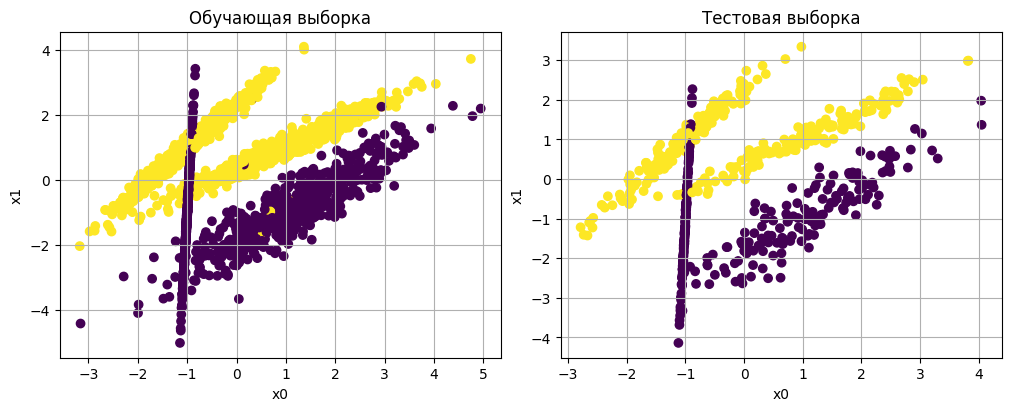

In [2]:
x, y = sk.datasets.make_classification(n_samples=3000, n_features=2, n_informative=2, n_redundant=0, n_repeated=0, random_state=3)
x_train, x_test, y_train, y_test = sk.model_selection.train_test_split(x, y, random_state=42, test_size = 0.2)

_, (ax0, ax1) = plt.subplots(1, 2, figsize=(2*5, 4))
ax0.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
ax0.set(xlabel='x0', ylabel='x1', title='Обучающая выборка')
ax1.scatter(x_test[:, 0], x_test[:, 1], c=y_test)
ax1.set(xlabel='x0', ylabel='x1', title='Тестовая выборка')

print(x_train.shape, y_train.shape)

## Задание №2

Найдите наилучшие параметры решающего дерева `DecisionTreeClassifier`.
Для этого постройте графики зависимостей _accuracy_ от сложности модели (максимального числа разделений) для обучающей и тестовой выборок.
После чего выберите оптимальное значение сложности модели.

**Замечание.**
Оптимальные параметры следует выбирать по наилучшему значению на тестовой выборке.
Если в исследуемой зависимости наблюдается несколько пиков с наилучшим значением, то стоит принять в рассмотрение также результат на обучающей выборке.

criterion: gini, max_depth: 10
max test accuracy: 0.99
criterion: entropy, max_depth: 6
max test accuracy: 0.9916666666666667


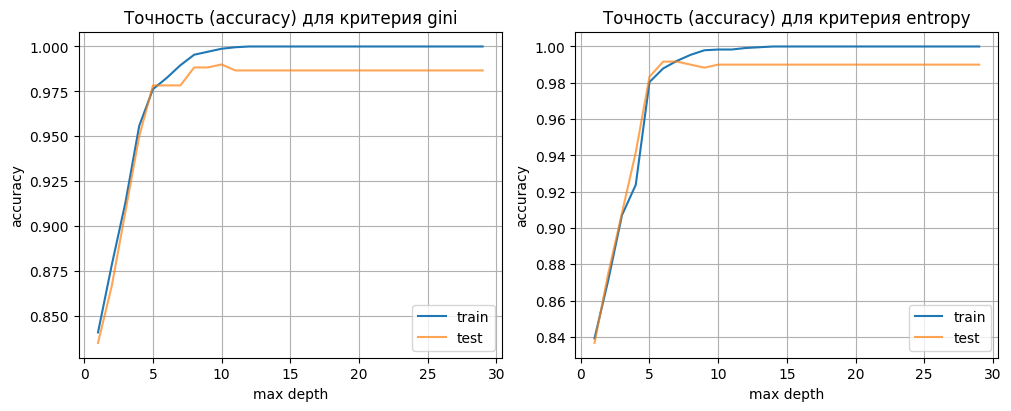

In [3]:
max_depth = range(1, 30)
criterions = ["gini", "entropy"]
_, axes = plt.subplots(1, len(criterions), figsize=(len(criterions)*5, 4))
for criterion, ax in zip(criterions, axes):
    metrics_train, metrics_test = [], []
    for depth in max_depth:
        model = sklearn.tree.DecisionTreeClassifier(criterion=criterion, splitter="best", max_depth=depth, random_state=0)
        model.fit(x_train,y_train)
        model.predict(x_test)
        metrics_train.append(model.score(x_train, y_train))
        metrics_test.append(model.score(x_test, y_test))
    
    ax.plot(max_depth, metrics_train, label='train')
    ax.plot(max_depth, metrics_test, label='test', alpha=0.7)
    ax.set(xlabel='max depth', ylabel='accuracy', title=f'Точность (accuracy) для критерия {criterion}')
    ax.legend()

    max_idx = np.argmax(metrics_test)
    
    print(f'criterion: {criterion}, max_depth: {max_depth[max_idx]}')
    print(f'max test accuracy: {metrics_test[max_idx]}')

**Вопросы:**

1. Какие критерии были рассмотрены?
1. Запишите полученную наилучшую точность и максимальное число разделений для каждого критерия.
1. Какой критерий разделения дает наилучший результат?
1. Наблюдается ли эффект переобучения (если да, то с чем он связан)?

**Ответы:**

1. В качестве критериев были рассмотрены индекс Джини и энтропия.
1. Максимальная точность на тестовом наборе около 0.990 для индекса Джини и 0.992 для энтропии.
1. Лучший результат даёт использование энтропии в качестве критерия.
1. Эффект переобучения не наблюдается.

Визуализируйте разделение пространства признаков для наилучшей модели.

train 0.9920833333333333
test 0.9916666666666667


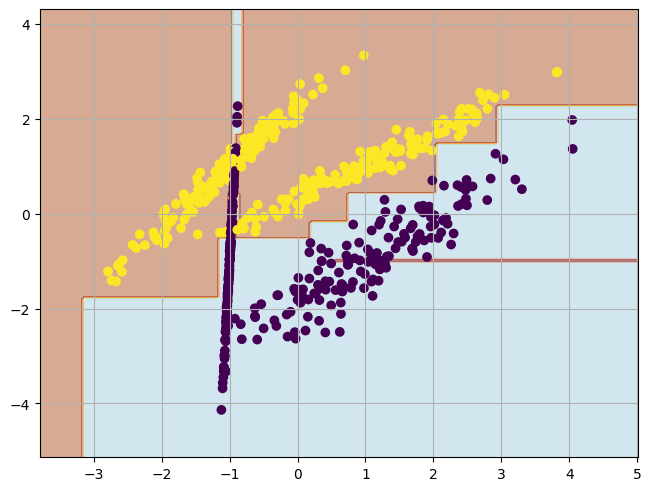

In [4]:
x_min, x_max = x_test[:, 0].min() - 1, x_test[:, 0].max() + 1
y_min, y_max = x_test[:, 1].min() - 1, x_test[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05), np.arange(y_min, y_max, 0.05))

best_model = sklearn.tree.DecisionTreeClassifier(criterion="entropy", splitter="best", max_depth=7, random_state=3)
best_model.fit(x_train,y_train)
Z = best_model.predict(np.c_[xx.ravel(), yy.ravel(), np.zeros((xx.ravel().shape[0], x_test.shape[1] - 2))])

plt.contourf(xx, yy, Z.reshape(xx.shape), cmap=plt.cm.Paired, alpha=0.5)
plt.scatter(x_test[:, 0], x_test[:, 1], c=y_test)
print('train', best_model.score(x_train, y_train))
print('test', best_model.score(x_test, y_test))

**Вопросы:**

1. Чем характерно отличается полученное разбиение от тех вариантов, что получались в прошлых лабораторных работах?

**Ответы:**

1. Для полученного разбиения харктерно деление пространства признаков прямыми линиями, расположенными строго вертикально или горизонтально.

## Задание №3

Найдите наилучшие параметры ансамбля, полученного баггингом `BaggingClassifier`.
Для этого воспользуйтесь функцией `GridSearchCV` с указанием кросс-валидации.
Рассмотрите такие параметры перебора:

* Максимальное число разделений (от 1 до 20)
* Максимальное доля обучающей выборки
* Количество деревьев в ансамбле (от 1 до 100)

Шаг для перебора каждого из параметров можете выбрать самостоятельно.
Визуализируйте разделение пространства признаков для наилучшей модели.

{'estimator': DecisionTreeClassifier(criterion='entropy', max_depth=7, random_state=0), 'max_samples': 1.0, 'n_estimators': 25}
train 0.9933333333333333
test 0.9966666666666667
CPU times: user 3.18 s, sys: 455 ms, total: 3.63 s
Wall time: 1min 20s


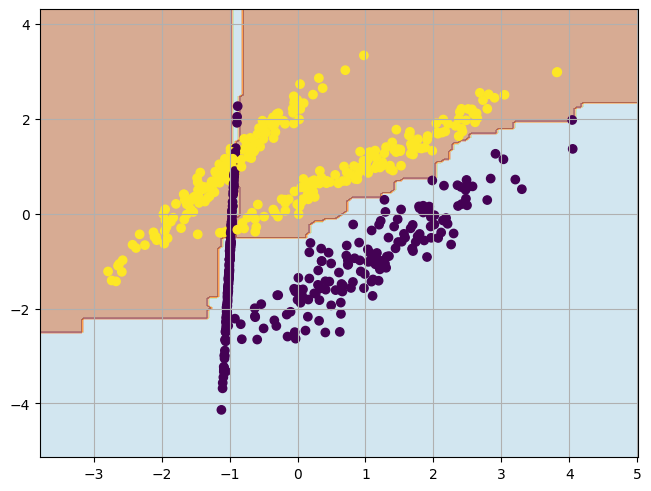

In [5]:
%%time

estimators = [
    sklearn.tree.DecisionTreeClassifier(
        criterion="entropy",
        splitter="best",
        max_depth=d,
        random_state=0
    )
    for d in range(1, 21, 3)
]
param_grid = {
    'estimator' : estimators,
    'max_samples' : np.linspace(0.01, 1, 5),
    'n_estimators' : np.linspace(1, 100, 5).astype(int)}

gs = sk.model_selection.GridSearchCV(sklearn.ensemble.BaggingClassifier(random_state=0),
                                     param_grid=param_grid, return_train_score=True, n_jobs=-1)
gs.fit(x_train, y_train)
Z = gs.predict(np.c_[xx.ravel(), yy.ravel(), np.zeros((xx.ravel().shape[0], x_test.shape[1] - 2))])

print(gs.best_params_)
print('train', gs.score(x_train, y_train))
print('test', gs.score(x_test, y_test))

plt.contourf(xx, yy, Z.reshape(xx.shape), cmap=plt.cm.Paired, alpha=0.5)
plt.scatter(x_test[:, 0], x_test[:, 1], c=y_test)

**Вопросы:**

1. Удалось ли увеличить качество модели по сравнению с одним распознающим деревом?
1. Как и почему изменилась форма разделяющей поверхности?
1. Как изменилась оптимальная сложность деревьев по сравнению с предыдущим заданием и с чем это связано?

**Ответы:**

1. Подбор параметров ансамбля позволил увеличить точность распознавания на несколько десятых долей процента.
1. Форма разделяющей поверхности стала более гладкой, т.к. определяется частотностью отнесения к тому или иному классу различными деревьями.
1. Оптимальная сложность деревьев увеличилась, т.к. максимальная глубина возрасла на 1 пункт.

Проанализируйте зависимости _accuracy_ от конкретных параметров.
Для этого используйте информацию из словаря `cv_results_`, беря во внимание полученные оптимальные параметры `best_params_`.
Постройте графики зависимости среднего значения _accuracy_ для каждого из параметров, фиксируя остальные параметры в значениях, взятых из `best_params_`.
Графики должны быть построены для обучающей и тестовой выборок, также показан разброс на тестовой выбоке (разброс вычисляется благодаря кросс-валидации).

{'estimator': DecisionTreeClassifier(criterion='entropy', max_depth=7, random_state=0), 'max_samples': 1.0, 'n_estimators': 25}


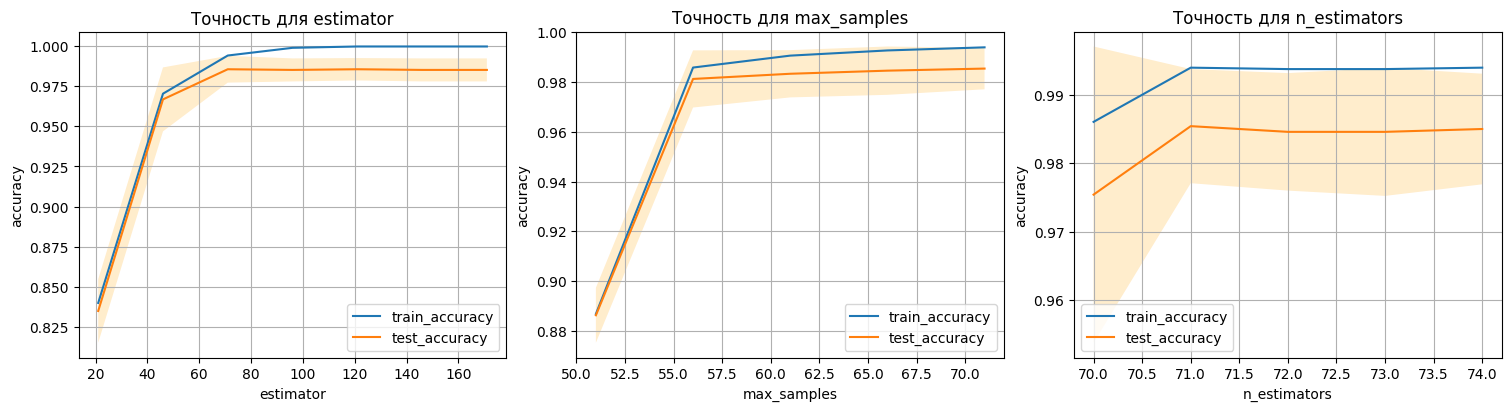

In [6]:
print(gs.best_params_)

_, axes = plt.subplots(1, len(gs.best_params_), figsize=(len(gs.best_params_)*5, 4))
for param, ax in zip(gs.best_params_.keys(), axes):
    reduced_dict = {k:v for k, v in gs.best_params_.items() if k != param}
    idx = [i for i, x in enumerate(gs.cv_results_['params']) if reduced_dict.items() <= x.items()]
    
    x, y, t, s = (gs.cv_results_[t][idx] for t in [f'param_{param}', 'mean_train_score', 'mean_test_score', 'std_test_score'])
    
    ax.plot(idx, y, label='train_accuracy')
    ax.plot(idx, t, label='test_accuracy')
    ax.fill_between(idx, t - 2 * s, t + 2 * s, facecolor='orange', alpha=.2)
    ax.set(xlabel=param, ylabel='accuracy', title=f'Точность для {param}')
    ax.legend()

**Вопросы:**

1. Опишите поведение графиков для каждого из параметров.
1. Изменился ли график максимального количества разбиения по сравнению с предыдущим вариантом? Почему?
1. Как связаны оптимальная сложность деревьев и количество распознающих деревьев?
1. За что отвечает параметр `max_samples`?

**Ответы:**

1. График каждого параметра монотонно возрастает.
1. Максимальное количество разбиений не изменилось.
1. Полученные результаты не говорят об этом, но оптимальная сложность деревьев влечёт за собой уменьшение их количества.
1. Параметр `max_samples` отвечает за число используемых для обучения элементов выборки.

## Задание №4

Подготовьте датасет mnist через функцию `load_digits` для дальнейшей работы.
Преобразуйте каждое изображение в одномерный вектор нормированных признаков.
Разделите датасет на обучающую и тестовую выборки.
Размер тестовой выборки следует выбрать равным 20% от размера всей выборки.
Не забудьте указать `random_state` для повторяемости результатов.

In [7]:
x, y = sklearn.datasets.load_digits(return_X_y=True)
x_train, x_test, y_train, y_test = sk.model_selection.train_test_split(x, y, random_state=42, test_size = 0.2)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(1437, 64) (360, 64) (1437,) (360,)


## Задание №5

Найдите наилучшие параметры для ансамблей, полученных баггингом, методом адаптивного бустинга, а также случайного леса с помощью `GridSearchCV`.
Выведите _accuracy_ для обучающей и тестовой выборок.
Параметры переборов:

* Макимальная глубина деревьев - от 1 до 20
* Количество деревьев - от 10 до 100
* `max_samples` и `max_features` - от 0 до 1

In [21]:
tree_prototype = sk.tree.DecisionTreeClassifier(random_state=4)

params = {
    'BaggingClassifier': {
        'proto': sk.ensemble.BaggingClassifier(estimator=tree_prototype, random_state=4),
        'grid': {
            'estimator__max_depth': np.linspace(1, 20, 5).astype(int),
            'n_estimators': np.linspace(10, 100, 5).astype(int),
            'max_samples': np.linspace(0.1, 1, 5),
        },
    },
    'RandomForestClassifier': {
        'proto': sk.ensemble.RandomForestClassifier(random_state=4),
        'grid': {
            'max_depth': np.linspace(1, 20, 5).astype(int),
            'n_estimators': np.linspace(10, 100, 5).astype(int),
            'max_features': np.linspace(0.1, 1, 5),
        },
    },
    'AdaBoostClassifier': {
        'proto': sk.ensemble.AdaBoostClassifier(estimator=tree_prototype,random_state=4),
        'grid': {
            'estimator__max_depth' : np.linspace(1, 20, 5).astype(int),
            'n_estimators' : np.linspace(10, 100, 5).astype(int),
        }
    }
}

for (name, param) in params.items():
    gs = sk.model_selection.GridSearchCV(param['proto'], param_grid=param['grid'], n_jobs=-1)
    %time gs.fit(x_train, y_train)
    print(name, gs.best_params_)
    print('train', gs.best_estimator_.score(x_train, y_train))
    print('test', gs.best_estimator_.score(x_test, y_test))

CPU times: user 10.3 s, sys: 854 ms, total: 11.2 s
Wall time: 2min 53s
BaggingClassifier {'estimator__max_depth': 15, 'max_samples': 1.0, 'n_estimators': 100}
train 1.0
test 0.9527777777777777
CPU times: user 4.66 s, sys: 777 ms, total: 5.44 s
Wall time: 2min 55s
RandomForestClassifier {'max_depth': 15, 'max_features': 0.1, 'n_estimators': 100}
train 1.0
test 0.975
CPU times: user 5 s, sys: 133 ms, total: 5.13 s
Wall time: 42.6 s
AdaBoostClassifier {'estimator__max_depth': 10, 'n_estimators': 100}
train 1.0
test 0.9805555555555555


**Вопросы:**

1. Какова оптимальная размерность подмножества случайно отбираемых признаков для случайного леса?
1. Какой метод позволил достичь наилучшего результата?
1. Что можно сказать о скорости обучения ансамблей?

**Ответы:**

1. Оптимальная размерность подмножества случайно отбираемых признаков случайного леса равна 15.
1. Наилучший результат на тестовой выборки был достигнут методом AdaBoost.
1. Наименьшее время обучения имеет метод случайных деревьев.